<a href="https://colab.research.google.com/github/ashikshafi08/Learning_Tensorflow/blob/main/Notebooks/05_Transfer_Learning_with_TensorFlow_Part_2_Fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Tue Mar 23 13:34:51 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Transfer Learning with Tensorflow: Fine Tuning 
In the previous notebook, we covered transfer learning feature extraction, now it's time to learn about a new kind of transfer learning which is **fine-tuning**.

## What we're going to cover

We're going to go through the follow with TensorFlow:

- Introduce fine-tuning, a type of transfer learning to modify a pre-trained model to be more suited to your data
- Using the **Keras Functional API** (a differnt way to build models in Keras)
- Using a smaller dataset to experiment faster (e.g. 1-10% of training samples of 10 classes of food)
- **Data augmentation** (how to make your training dataset more diverse without adding more data)

- Running a **series of modelling experiments** on our Food Vision data
  - Model 0: a transfer learning model using the Keras Functional API
  - Model 1: a feature extraction transfer learning model on 1% of the data with data augmentation
  - Model 2: a feature extraction transfer learning model on 10% of the data with data augmentation
  - Model 3: a fine-tuned transfer learning model on 10% of the data
  - Model 4: a fine-tuned transfer learning model on 100% of the data
- Introduce the **ModelCheckpoint callback** to save intermediate training results
- Compare model experiments results using TensorBoard

## Creating helper function
In previous notebooks, we've created a bunch of helper functions now we could re-write them all. However this is tedious. So it's a good idea to put all those function you want to use in a script, with that we can import them later depending upon our use. 

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-03-23 13:34:52--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9304 (9.1K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   9.09K  --.-KB/s    in 0s      

2021-03-23 13:34:53 (107 MB/s) - ‘helper_functions.py’ saved [9304/9304]



In [3]:
# Import helper function 
from helper_functions import create_tensorboard_callback , plot_loss_curves , unzip_data , walk_through_dir

> **Dan Note:** If you're running this notebook in Colab, when it times out in Colab will delete `helper_functions.py` so you'll have to redownload it if you want access to your helper function. 

## Let's get some data 
This time we're going to see how to use the pre-trained models within `tf.keras.applications` and apply them to our own problem recognizing images of food. 

https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [4]:
# Get 10% of training data of 10 classes of Food101 
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data('10_food_classes_10_percent.zip')

--2021-03-23 13:34:55--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   152MB/s    in 1.1s    

2021-03-23 13:34:56 (152 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
# Check out how many images and sub directories are in our dataset 
walk_through_dir('10_food_classes_10_percent')

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/gr

In [6]:
# Create training and test directory path 
train_dir = '10_food_classes_10_percent/train'
test_dir = '10_food_classes_10_percent/test'

In [7]:
import tensorflow as tf

# Global image size , batch 
IMG_SIZE = (224 , 224)
BATCH_SIZE = 32

# Using the image_dataset_from_directory
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory= train_dir , 
                                                                            image_size = IMG_SIZE , 
                                                                            label_mode = 'categorical' , 
                                                                            batch_size = BATCH_SIZE)

test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(test_dir, 
                                                                           image_size = IMG_SIZE,  
                                                                           label_mode = 'categorical')

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [8]:
train_data_10_percent

<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [9]:
# Check out class names of our dataset 
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [10]:
# Seeing an example of batch
for images ,labels in train_data_10_percent.take(1): # take unravel a batch 
  print(images , labels)

tf.Tensor(
[[[[196.54082   163.82652   125.59694  ]
   [200.18878   171.04082   136.92346  ]
   [179.72958   156.15816   129.0153   ]
   ...
   [192.14279   145.58156    49.020313 ]
   [186.92856   137.57141    42.66327  ]
   [189.58171   139.86743    47.224575 ]]

  [[193.74489   164.88776   128.14795  ]
   [194.35204   167.2704    136.77551  ]
   [186.03062   165.2449    138.88776  ]
   ...
   [203.52539   158.98462    63.714226 ]
   [189.79079   144.71426    51.653038 ]
   [187.31116   142.83163    51.428535 ]]

  [[189.37244   163.94897   133.71939  ]
   [186.61224   163.39796   135.89796  ]
   [182.2551    163.44897   141.16327  ]
   ...
   [209.55112   162.40321    68.1124   ]
   [202.4336    158.09178    62.948933 ]
   [186.12218   142.90788    48.693604 ]]

  ...

  [[226.21426   229.21426   236.21426  ]
   [226.94388   229.94388   236.94388  ]
   [228.        231.        238.       ]
   ...
   [181.78574   156.57147   127.214264 ]
   [183.85718   158.64291   129.2857   ]
   [1

## Model 0: Building a Transfer Learning model (Feature Extraction) using the Keras Functional API

The sequential API is straight-forward, it runs our layers in Sequential order.

But the functional API gives us more flexibility with our model. 
https://www.tensorflow.org/guide/keras/functional

In [11]:
# 1. Create a base model with tf.keras.applications 
base_model = tf.keras.applications.EfficientNetB0(include_top= False)

# 2. Freeze the base_model  (so the underlying pre-trained patterns aren't updated during training)
base_model.trainable = False

# 3. Create inputs into our model 
inputs = tf.keras.layers.Input(shape = (224 , 224, 3) , name = 'input_layer')

# 4. If you're using a model like ResNet50V2 you will need to normalize the inputs (no need for EfficientNet)
# x = tf.keras.experimental.preprocessing.Rescaling(1 / 255.)(inputs)

# 5. Pass the inputs to the base model 
x = base_model(inputs)
print(f'Shape after passing inputs through base_model {x.shape}')

# 6. Average Pool the outputs of the base model (aggregate all the most important info, reduce the number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name = 'global_average_pooling_layer')(x) # atlast multiplying means passing onto another layer
print(f'Shape aftr Global Average Pooling 2D: {x.shape}')

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10 , activation ='softmax' , name ='output_layer')(x)

# 8. Combine the inputs with the outputs into a model 
model_0 = tf.keras.Model(inputs , outputs)

# 9. Compile the model 
model_0.compile(loss = tf.keras.losses.CategoricalCrossentropy(), 
                optimizer = tf.keras.optimizers.Adam() , 
                metrics = ['accuracy'])

# 10. Fit and save the history 
history_0 = model_0.fit(train_data_10_percent , 
                        steps_per_epoch = len(train_data_10_percent) , 
                        epochs = 5 , 
                        validation_data = test_data_10_percent , 
                        validation_steps = int( 0.25 *len(test_data_10_percent)) , 
                        callbacks = [create_tensorboard_callback('transfer_learning' , 
                                                                 '10_percent')])

16711680/16705208 [==============================] - 0s 0us/step
Shape after passing inputs through base_model (None, 7, 7, 1280)
Shape aftr Global Average Pooling 2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent/20210323-133506
Epoch 1/5
24/24 [==============================] - 45s 345ms/step - loss: 2.1030 - accuracy: 0.2538 - val_loss: 1.3400 - val_accuracy: 0.7352
Epoch 2/5
24/24 [==============================] - 6s 224ms/step - loss: 1.1862 - accuracy: 0.7747 - val_loss: 0.8953 - val_accuracy: 0.8109
Epoch 3/5
24/24 [==============================] - 6s 226ms/step - loss: 0.8547 - accuracy: 0.8091 - val_loss: 0.7236 - val_accuracy: 0.8306
Epoch 4/5
24/24 [==============================] - 6s 224ms/step - loss: 0.6705 - accuracy: 0.8439 - val_loss: 0.6613 - val_accuracy: 0.8372
Epoch 5/5
24/24 [==============================] - 6s 224ms/step - loss: 0.5990 - accuracy: 0.8894 - val_loss: 0.5920 - val_accuracy: 0.8536


In [12]:
# Evaluate on the full test data 
model_0.evaluate(test_data_10_percent)

79/79 [==============================] - 10s 122ms/step - loss: 0.5990 - accuracy: 0.8476


[0.5990084409713745, 0.847599983215332]

In [13]:
# Check the layers in our base model 
for layer_number , layer in enumerate(base_model.layers):
  print(layer_number , layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [14]:
# Summary of the base model 
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, None, None, 3 7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization[0][0]              
_____________________________________________________________________________________

In [15]:
# Summary of the model_0 
model_0.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


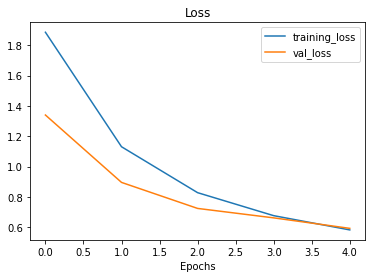

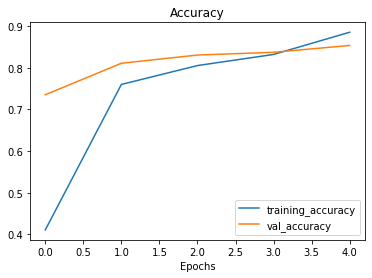

In [16]:
# Check our our model's training curves 
plot_loss_curves(history_0)

## Getting a feature vector from the trained model 

Let's demonstrate the Global Average Pooling 2D layer....

We have a tensor after our model goes through `base_model` of shape (None , 7 , 7 , 1280)....

But when it passes through GlobalAveragePooling2D layer it turns into (None , 1280). 

Let's use a similar shape tensor of (1,4,4,3) and then pass it to GlobalAveragePooling2D. 

In [17]:
# Define the input shape 
input_shape = (1 , 4, 4, 3)

# Create a random tensor 
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f'Random input tensor:\n {input_tensor}\n')

# Pass the random tensor to a GlobalAveragePool2d Layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor) # Same like using the functional api
print(f'2D Global average pooled random tensor:\n {global_average_pooled_tensor} ')

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D Global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]] 


In [18]:
# Check the shape of different tensors 
print(f'Shape of the input_tensor: {input_tensor.shape}')
print(f'Shape of the GlobalAveragePooling2D layer: {global_average_pooled_tensor.shape}')

Shape of the input_tensor: (1, 4, 4, 3)
Shape of the GlobalAveragePooling2D layer: (1, 3)


In [19]:
# Lets replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor , axis = [1 , 2]) # Take mean across this axis (1, 2) 

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

Do the same thing above but with `GlobalMaxPool2D`